In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [47]:
def plot_losses(tr, va):
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots()
  ax.plot(tr, label='train')
  ax.plot(va, label='validation')
  plt.show()

In [25]:
df = pd.read_csv("./data/norm_df.csv")
df.index = pd.to_datetime(df.index)
df.head()

,consumption,temperature,region,time_of_day,time_of_week,time_of_month,time_of_year,consumption_24h_lag,consumption_yday_mean,consumption_prev
2017-05-01 00:00:00+00:00,0.219890,-0.700416,1,0,0,1,5,0.219809,0.433275,0.219886
2017-05-01 01:00:00+00:00,0.236287,-0.563661,1,1,0,1,5,0.219809,0.433275,0.219886
2017-05-01 02:00:00+00:00,0.281981,-0.454256,1,2,0,1,5,0.219809,0.433275,0.236283
2017-05-01 03:00:00+00:00,0.309108,-0.508958,1,3,0,1,5,0.219809,0.433275,0.281977
2017-05-01 04:00:00+00:00,0.459408,-0.536309,1,4,0,1,5,0.219809,0.433275,0.309104


In [26]:
df = df[['temperature', 'consumption', 'consumption_24h_lag']].copy()
df.head()

,temperature,consumption,consumption_24h_lag
2017-05-01 00:00:00+00:00,-0.700416,0.219890,0.219809
2017-05-01 01:00:00+00:00,-0.563661,0.236287,0.219809
2017-05-01 02:00:00+00:00,-0.454256,0.281981,0.219809
2017-05-01 03:00:00+00:00,-0.508958,0.309108,0.219809
2017-05-01 04:00:00+00:00,-0.536309,0.459408,0.219809


In [27]:
target_feature = 'consumption'
features = list(df.columns.difference([target_feature]))

forecast_lead = 24
target = f"{target_feature}_lead{forecast_lead}"

df[target] = df[target_feature].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

df.tail()

,temperature,consumption,consumption_24h_lag,consumption_lead24
2023-01-20 19:00:00+00:00,-1.603004,-0.545273,-0.596270,-0.653067
2023-01-20 20:00:00+00:00,-1.603004,-0.584726,-0.616439,-0.689987
2023-01-20 21:00:00+00:00,-1.698733,-0.624802,-0.652967,-0.722259
2023-01-20 22:00:00+00:00,-1.685058,-0.657174,-0.695173,-0.755219
2023-01-20 23:00:00+00:00,-1.671382,-0.690093,-0.730260,-0.794111


In [36]:
validation_start = "2022-01-01"
test_start = "2022-06-20"

df_train = df.loc[:validation_start].copy()
df_val = df.loc[validation_start:test_start].copy()
df_test = df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.10316473850272492


In [29]:
df_train.head()

,temperature,consumption,consumption_24h_lag,consumption_lead24
2017-05-01 00:00:00+00:00,-0.700416,0.219890,0.219809,0.121633
2017-05-01 01:00:00+00:00,-0.563661,0.236287,0.219809,0.157199
2017-05-01 02:00:00+00:00,-0.454256,0.281981,0.219809,0.225990
2017-05-01 03:00:00+00:00,-0.508958,0.309108,0.219809,0.356080
2017-05-01 04:00:00+00:00,-0.536309,0.459408,0.219809,0.795800


In [30]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=24):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.Tensor(dataframe[target].values).float()
        self.X = torch.Tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if idx >= self.sequence_length - 1:
            i_start = idx - self.sequence_length + 1
            x = self.X[i_start:(idx + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - idx - 1, 1)
            x = self.X[0:(idx + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[idx]

In [37]:
train_dataset = SequenceDataset(df_train, target, features)
val_dataset = SequenceDataset(df_val, target, features)
test_dataset = SequenceDataset(df_test, target, features)



In [40]:
torch.manual_seed(42)

batch_size = 32
sequence_length = 24

train_dataset = SequenceDataset(
    df_train, 
    target = target, 
    features = features, 
    sequence_length=sequence_length
)

val_dataset = SequenceDataset(
    df_val,
    target = target,
    features = features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_test,
    target = target,
    features = features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: torch.Size([32, 24, 2])
Target shape: torch.Size([32])


In [49]:
class LSTMModel(nn.Module):
    def __init__(self, num_features, hidden_units, use_cuda=False):
        super().__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()
        return out
                 

In [43]:
lr = 5e-5
num_hidden_units = 16

model = LSTMModel(num_features=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [45]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        optimizer.zero_grad()
        y_hat = model(X)
        loss = loss_function(y_hat, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss:.4f}")

def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            y_hat = model(X)
            total_loss += loss_function(y_hat, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")

In [46]:
print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(2):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 0.681513454001052

Epoch 0
---------
Train loss: 0.1697
Test loss: 0.052458772998314675

Epoch 1
---------
Train loss: 0.0503
Test loss: 0.046205610771919314



0 - train: 0.07548904076347494, valid: 0.04888701718926177
1 - train: 0.04189361400741668, valid: 0.04426192241037958


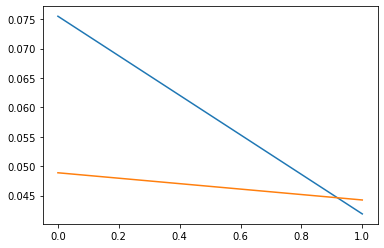

In [52]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

model = lr = 5e-5
num_hidden_units = 16

model = LSTMModel(num_features=len(features), hidden_units=num_hidden_units, use_cuda=USE_CUDA).to(device)

lr = 4e-4
n_epochs = 2
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

t_losses, v_losses = [], []

for epoch in range(n_epochs):
    train_loss, val_loss = 0.0, 0.0

    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()

        x = x.to(device)
        y = y.squeeze().to(device)
        #print(f"x shape: {x.shape}, y shape: {y.shape}")
        #print(x)
        preds = model(x)#.squeeze()
        #print(f"preds shape: {preds.shape}")
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_loader)
    t_losses.append(epoch_loss)

    # validation
    model.eval()
    for x, y in val_loader:
        with torch.no_grad():
            x = x.to(device)
            y = y.squeeze().to(device)
            preds = model(x).squeeze()
            error = criterion(preds, y)
        val_loss += error.item()
    val_loss = val_loss / len(val_loader)
    v_losses.append(val_loss)

    print(f'{epoch} - train: {epoch_loss}, valid: {val_loss}')
plot_losses(t_losses, v_losses)